This article is a compilation of the notes I took during my deep dive into understanding the Transformer architecture. I would like to acknowledge [The Annotated Transformer](https://nlp.seas.harvard.edu/annotated-transformer/) for providing such a detailed and insightful guide, complete with code, on the Transformer. Much of the code I wrote, especially the model architecture, references their work.

Throughout my learning journey, I've noticed that there are already many excellent tutorials about Transformer out there. Nonetheless, I hope that my write up here could serve as a companion and offer you another perspective on the subject. Everything you see here is also available as a notebook that you can run at [my GitHub link]().

# Background

The Transformer architecture, introduced in the landmark paper *[Attention is All You Need](https://arxiv.org/abs/1706.03762)* in 2017, has played a pivotal role in the development of large language models (LLMs) like ChatGPT, Claude, and Gemini. Originally designed for machine translation, the Transformer model was later adapted for a variety of other tasks, including chat conversations, named entity recognition, text summarization, and more.

This article focuses on the original Transformer model used for machine translation, which was developed to address two major limitations of earlier models like RNNs and LSTMs:

1. **Limited Memory for Long Sequences**: RNNs and LSTMs struggled to retain information over long sequences due to their sequential nature. This limitation is similar to the "Telephone" game, where a message gets increasingly distorted as it is passed along.

2. **Inefficient Training Speed**: The sequential processing of words in RNNs and LSTMs meant that each word's processing depended on the previous one. This dependency limited parallel processing, significantly slowing down training and preventing the full utilization of GPU capabilities.

The transformative feature of the Transformer architecture is its multi-headed attention mechanism. This mechanism enables the model to understand the context and meaning of each word in a sentence, distinguishing between different uses of the same word, such as "bank" in "river bank" versus "commercial bank."

In [1]:
# Importing the required libraries
import os
import random
import time
import math
import torch
import copy

from datasets import load_dataset
from nltk.translate.bleu_score import corpus_bleu
from torch import nn
from torch.nn.functional import pad
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
import configs

import matplotlib.pyplot as plt
import re
import numpy as np
from torch.functional import F

/home/leonseet/Documents/personal/reannotated-transformer/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_device(gpu=None):
    """
    Get the device to be used for training
    """
    if torch.cuda.is_available():
        return torch.device(f"cuda:{gpu}")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")


DEVICE = get_device(configs.TRAIN_GPU)  # Automatically use GPU if available, input GPU device number if you want to use a specific GPU

# Transformer Architecture

In this article, we'll take a top-down approach to understanding the Transformer architecture, which I believe is the most effective way to grasp the model. The following figures illustrate both the original Transformer architecture and a revised version that we will be implementing. The main difference between them lies in the position of the layer normalization: in the revised architecture, we'll perform pre-layer normalization instead of post-layer normalization. We'll explore this change in more detail later.

<div style="display: flex; justify-content: center;">
  <div style="margin-right: 10px; text-align: center;">
    <img src="images/original_transformer_arch.png" alt="Image 1" height="500"/>
    <p style="text-align: center;"><em>Original Transformer Architecture. <a href="https://arxiv.org/pdf/1706.03762">source</a></em></p>
  </div>
  <div style="text-align: center;">
    <img src="images/revised_transformer_arch.png" alt="Image 2" height="500"/>
    <p style="text-align: center;"><em>Revised Transformer Architecure with Pre-layer Norm.</em></p>
  </div>
</div>

As we examine the entire architecture, you'll notice that it's composed of several key components. Let's now walk through each component in detail.

## Transformer

The Transformer Block encompasses all the components that make up the entire architecture in the Revised Transformer Model. It includes the embedding layers, encoder layers, decoder layers, and the generator. The generator handles the final linear transformation and softmax operation near the output of the decoder.

In [3]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_emb, tgt_emb, generator):
        super().__init__()
        self.src_emb = src_emb
        self.tgt_emb = tgt_emb
        self.encoder = encoder
        self.decoder = decoder
        self.generator = generator

    def encode(self, x, src_mask):
        x = self.src_emb(x)
        x = self.encoder(x, src_mask)
        return x

    def decode(self, enc_out, src_mask, y, tgt_mask):
        y = self.tgt_emb(y)
        y = self.decoder(y, enc_out, src_mask, tgt_mask)
        return y

    def forward(self, x, y, src_mask, tgt_mask):
        x = self.encode(x, src_mask)
        y = self.decode(x, src_mask, y, tgt_mask)
        return y


## Generator

<div style="text-align: center;">
  <img src="images/arch_generator.png" alt="Example Image" height="500"/>
  <p>
    <em>The Generator Consisting of Linear and Softmax Layers.</em></p>
  </p>
</div>

Notice that the Generator uses Log Softmax instead of the standard Softmax function in the code snippet below. Log Softmax is simply the logarithm applied after Softmax, but this small change has significant benefits.

The Softmax function works by taking the exponential of each element in a vector, which can cause very large values to become even larger and very small values to shrink further. This process can lead to numerical instability, as extreme values can cause the function to produce outputs that are either too large or too small to handle effectively.

Log Softmax, on the other hand, transforms the output probabilities into a more balanced range (as shown below) by applying the logarithm, reducing the extremes and resulting in a more stable distribution.

<div style="text-align: center;">
  <img src="images/log_softmax_vs_softmax.png" alt="Example Image" width="500"/>
  <p>
    <em>Comparison of Softmax and Log Softmax. <a href="https://www.baeldung.com/cs/softmax-vs-log-softmax#:~:text=When%20calculating%20the%20gradient%2C%20the,training%2C%20especially%20for%20complex%20models">source</a></em></p>
  </p>
</div>


In backpropagation, the derivative of Log Softmax is also more numerically stable compared to that of Softmax. The Softmax derivative involves division, which can result in NaN (Not a Number) outputs if the denominator becomes unstable or approaches zero. In contrast, the derivative of Log Softmax avoids this issue because it doesn’t involve division, leading to more reliable gradient calculations during training.

In [4]:
class Generator(nn.Module):
    def __init__(self, d_model, vocab_size):
        super().__init__()
        self.linear = nn.Linear(d_model, vocab_size)

    def forward(self, x, logits=False):
        x = self.linear(x)
        if logits:
            return x
        else:
            return F.log_softmax(x, dim=-1)

## Layer Normalization

<div style="text-align: center;">
  <img src="images/arch_layernorm.png" alt="Layer Normalization" height="500"/>
  <p>
    <em>Layer Normalization.</em></p>
  </p>
</div>

We opted for pre-layer normalization (Pre-LN) instead of post-layer normalization (Post-LN) in our model to stabilize the gradients as the model depth increases. The chart below compares the average gradient magnitudes of weights in the Transformer's FFN sub-layers for three scenarios: Pre-LN, Post-LN, and Post-LN with a learning rate warm-up.

With Pre-LN, the gradient magnitudes remain relatively stable across increasing layers, indicating better gradient flow. In contrast, Post-LN shows a rapid increase in gradient magnitude as the layers deepen, which can lead to gradient explosion during training. The Post-LN with warm-up introduces a learning rate scheduling mechanism early in training, which helps maintain small and consistent gradients. This is generally a positive outcome, but it also introduces additional hyperparameters that require careful tuning, making the training process more complex.

Although we utilized Pre-LN to avoid the need for warm-up scheduling, we will still utilize warm-up during training later for learning purposes. 

<div style="text-align: center;">
  <img src="images/pre_vs_post_layernorm.png" alt="Example Image" height="200"/>
  <p>
    <em>Average Magnitude of Gradients for Weight Matrices, W¹ and W², in the FFN sub-layers. <a href="https://arxiv.org/pdf/2002.04745">source</a></em></p>
  </p>
</div>




In [5]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        x_mean = x.mean(dim=-1, keepdim=True)
        x_std = x.std(dim=-1, keepdim=True)
        x = (x - x_mean) / (x_std + self.eps)
        x = self.gamma * x + self.beta
        return x

## Encoder

<div style="text-align: center;">
  <img src="images/arch_encoder.png" alt="Encoder" height="500"/>
  <p>
    <em>Encoder.</em></p>
  </p>
</div>

In the context of machine translation, the encoder plays a crucial role in transforming a sentence into a meaningful representation that a model can understand and work with. Initially, the encoder takes in the sentence (which is German in our case) without any inherent understanding of its meaning. However, as the sentence passes through the encoder, it transforms into a rich representation that encapsulates not just the meanings of individual words, but also the complex relationships between them within the context of the entire sentence. This encoded representation can be utilized for a variety of tasks such as classification, text summarization, and more. In our case, this information will be passed to the Decoder's Multi-Head Cross Attention for further processing. We'll dive into the differences between cross-attention and self-attention shortly.

In [6]:
def clones(module, n):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(n)])


class SublayerConnection(nn.Module):
    def __init__(self, d_model, p):
        super().__init__()
        self.dropout = nn.Dropout(p)
        self.layernorm = LayerNorm(d_model)

    def forward(self, x, sublayer):
        x_ = x.clone()
        x = self.layernorm(x)
        x = sublayer(x)
        x = self.dropout(x)
        x += x_
        return x


class EncoderLayer(nn.Module):
    def __init__(self, mha, ffn, d_model, p):
        super().__init__()
        self.mha = mha
        self.ffn = ffn
        self.sublayers = clones(SublayerConnection(d_model, p), 2)
        self.d_model = d_model

    def forward(self, x, enc_self_mask):
        x = self.sublayers[0](x, lambda x: self.mha(x, x, x, enc_self_mask))
        x = self.sublayers[1](x, lambda x: self.ffn(x))
        return x


class Encoder(nn.Module):
    def __init__(self, layer, n_layers):
        super().__init__()
        self.layers = clones(layer, n_layers)
        self.layernorm = LayerNorm(layer.d_model)

    def forward(self, x, enc_self_mask):
        for layer in self.layers:
            x = layer(x, enc_self_mask)
        x = self.layernorm(x)
        return x

## Decoder

<div style="text-align: center;">
  <img src="images/arch_decoder.png" alt="Decoder" height="500"/>
  <p>
    <em>Decoder.</em></p>
  </p>
</div>

On the other hand, the decoder takes this encoded representation (which is the rich representation from the encoder) and combines it with the translated sentence, which initially consists of a special \<bos\> token (beginning of sentence). The decoder then generates words one at a time, producing a probability distribution over possible words from the target language (in our case, English). Depending on the decoding strategy, a word is sampled from this distribution as the next token to be generated. This new token is appended to the target sequence and fed back into the decoder to generate the following word. This iterative process continues until either a maximum sequence length is reached or a special \<eos\> token (end of sentence) is generated, signaling the end of the translation.

What I have just described for the encoder and decoder is what happens during model inference which differs slightly for model training. In model training, the entire translated sentence is passed into the decoder and not one word at a time. To prevent the model from seeing the entire sentence during training, a mask is added to hide future words from the sentence which is applied in the self-attention mask in the decoder.

In [7]:
class DecoderLayer(nn.Module):
    def __init__(self, self_mha, cross_mha, ffn, d_model, p):
        super().__init__()
        self.self_mha = self_mha
        self.cross_mha = cross_mha
        self.ffn = ffn
        self.sublayers = clones(SublayerConnection(d_model, p), 3)
        self.d_model = d_model

    def forward(self, y, x, src_mask, tgt_mask):
        y = self.sublayers[0](y, lambda y: self.self_mha(y, y, y, tgt_mask))
        y = self.sublayers[1](y, lambda y: self.cross_mha(y, x, x, src_mask))
        y = self.sublayers[2](y, lambda y: self.ffn(y))
        return y


class Decoder(nn.Module):
    def __init__(self, layer, n_layers):
        super().__init__()
        self.layers = clones(layer, n_layers)
        self.layernorm = LayerNorm(layer.d_model)

    def forward(self, y, x, src_mask, tgt_mask):
        for layer in self.layers:
            y = layer(y, x, src_mask, tgt_mask)
        y = self.layernorm(y)
        return y

## Multi Head Attention

<div style="text-align: center;">
  <img src="images/arch_mha.png" alt="Multi-Head Attention" height="500"/>
  <p>
    <em>Multi-Head Attention.</em></p>
  </p>
</div>

The attention mechanism, which is the core of the Transformer model, is where the magic happens. After coming across many analogies online, I found [this article by Eugene Yan](https://eugeneyan.com/writing/attention/) to offer one of the best analogy:

> Imagine yourself in a library. You have a specific question (query). Books on the shelves have titles on their spines (keys) that suggest their content. You compare your question to these titles to decide how relevant each book is, and how much attention to give each book. Then, you get the information (value) from the relevant books to answer your question.

As shown in the architecture diagram above, after the first Pre-LN, the weight matrix is split into three components: query (q), key (k), and value (v). These are all derived from the initial weight matrix but serve different purposes in the attention mechanism. Attention fundamentally relies on two key operations: matrix multiplication and the softmax function. 

First, the query is compared to the key using a dot product through matrix multiplication, which determines how relevant each key is to the query. The relevance of each key is then quantified using the softmax function, which converts these relevance scores into a probability distribution that sums to 1. Finally, the "meaning" of the relevant information is extracted by performing another matrix multiplication with the value vector.


<div style="text-align: center;">
  <img src="images/mha.png" alt="Multi-Head Attention in Detail" height="500"/>
  <p>
    <em>Multi-Head Attention in Detail.</em></p>
  </p>
</div>

In the Multi-Head Attention mechanism a shown in the figure above, the term "multi-head" refers to splitting the embedding dimension into multiple segments. These segments are processed in parallel, and the results are then stacked back together. The purpose of having multiple heads is to introduce diversity into the representation of each word after attention is applied.

For instance, take the sentence "The quick brown fox jumps over the lazy dog." If we focus on the word "fox," different heads might attend to different aspects of the sentence. One head might focus on the appearance of the fox, such as "brown," another might focus on the action, such as "jumps," and a third might focus on the interaction with "dog." By aggregating the outputs from all heads at the end of the MHA, we achieve a more comprehensive and nuanced representation of the word "fox" in the embedding vectors. For visual learners, I highly recommend [this video by 3Blue1Brown](https://www.youtube.com/watch?v=eMlx5fFNoYc) to understand the intuition of MHA.

As we have alluded previously, there are 2 types of attention mechanism used in the Transformer model, self-attention and cross-attention. 

Self-attention is used both in the encoder and in the first Multi-Head Attention (MHA) layer of the decoder. In this mechanism, the query, key, and value are derived from the same source, which is the input sentence. The purpose of self-attention is to help the model determine which words within the sentence are most significant and should be focused on. By calculating the relationships between each word in the sentence, the model learns to prioritize certain words over others, depending on their importance in the context of the sentence.

Cross-attention, on the other hand, is used in the second MHA layer of the decoder and functions differently. Here, the query and key are not the same. In the context of machine translation, for instance, from German to English, the query is derived from the translated language (English), while the key is derived from the source language (German). The cross-attention mechanism allows the model to create a similarity matrix between the query (English) and the key (German). This matrix helps the model understand which German words should be given more attention for each English word during the translation process.

The values (v) that are utilized after applying the softmax function in this mechanism are derived from the key (German). These key and value come from the encoder's output, which means that the model is effectively using information from the original German sentence to inform the translation process into English.

In [8]:
def scaled_dot_attention(q, k, v, mask, dropout):
    d_k = q.shape[-1]
    attn = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        attn = attn.masked_fill(mask == 0, -1e9)
    attn = F.softmax(attn, -1)
    if dropout is not None:
        attn = dropout(attn)

    value = torch.matmul(attn, v)
    return value, attn


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, p=0.1):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_k = d_model // n_heads
        self.n_heads = n_heads
        self.dropout = nn.Dropout(p)
        self.linears = clones(nn.Linear(d_model, d_model), 4)

    def forward(self, q, k, v, mask=None):
        batch_size, max_seq_len, _ = q.shape
        q = self.linears[0](q)
        k = self.linears[1](k)
        v = self.linears[2](v)
        q = q.reshape(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        k = k.reshape(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        v = v.reshape(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)

        if mask is not None:
            mask = mask.unsqueeze(1)

        value, attn = scaled_dot_attention(q, k, v, mask, self.dropout)
        value = value.transpose(1, 2).reshape(batch_size, max_seq_len, self.n_heads * self.d_k)
        value = self.linears[3](value)

        del q
        del k
        del v
        return value

## Position-wise Feed-Forward Networks

<div style="text-align: center;">
  <img src="images/arch_poswiseffn.png" alt="Position-wise FFN" height="500"/>
  <p>
    <em>Position-wise FFN.</em></p>
  </p>
</div>

This method is called 'Position Wise' because the FFN operates on the embedding dimension of each sequence element individually, rather than on the sequence as a whole. Imagine a sentence where each word is represented by a vector. In this approach, the same FFN is applied to each word's vector independently. Therefore, if the same word appears in multiple positions within the sentence, it will produce the same output after passing through the FFN. Importantly, the vectors of one word do not interact with the vectors of another word in this process. This is why the term 'Position Wise' is used to describe this method.

In [9]:
class PositionWiseFFN(nn.Module):
    def __init__(self, d_model, p=0.1):
        super().__init__()
        self.expand_linear = nn.Linear(d_model, d_model * 4)
        self.shrink_linear = nn.Linear(d_model * 4, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        x = self.expand_linear(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.shrink_linear(x)
        return x

## Embedding Layer & Positional Encoding

<div style="text-align: center;">
  <img src="images/arch_emb.png" alt="Embedding Layer & Positional Encoding" height="500"/>
  <p>
    <em>Embedding Layer & Positional Encoding.</em></p>
  </p>
</div>


In Transformer models, the Embedding Layer plays a crucial role in converting tokens into their corresponding embedding vectors. You can think of this layer as a kind of Python dictionary, where the token IDs are the keys, and the embedding vectors are the values. When you input a list of tokens into the Embedding Layer, it retrieves the embedding vectors for each token from this "dictionary."

One important aspect to note is that during the forward pass, the embedding vectors are scaled by the square root of the embedding dimension. This scaling ensures that the values of the embedding vectors are not significantly smaller than the values of the positional encodings (ranges between -1 to 1) that are added to them. Without this scaling, the positional encoding could overpower the embedding vectors, which would disrupt the model's ability to differentiate between the actual token meanings and their positional context.

Positional encoding is essential in Transformers because, unlike RNNs, Transformers don't inherently understand the order of tokens. Positional encoding provides the model with information about the position of each token in a sequence, enabling it to understand the relative distances between words. For instance, the word "She" five sentences away might refer to a different entity than "She" in the current sentence. This positional awareness is crucial for the model's comprehension.

There are various strategies to incorporate positional information, such as learned positional encodings or rotary positional encodings. In this article, we'll focus on the sinusoidal positional encoding, as used in the original Transformer paper. The sinusoidal encoding is calculated using the following formulas:

$$
PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
$$
$$
PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
$$
Where:
- **i** is the dimension index,
- **d_model** is the embedding length,
- **pos** is the position of the word in the sentence.

The sinusoidal positional encoding has several advantages. First, it can be precomputed, meaning it doesn’t add to the number of learnable parameters in the model. This reduces the overall complexity of the model. Additionally, because the sine and cosine functions are periodic and output values constrained between -1 and 1, they naturally fit well for encoding positional information. Another benefit is that these encodings allow the model to generalize to sequences longer than those seen during training, as the functions smoothly extrapolate beyond the training sequence lengths. This would not have been possible if we were to use learned positional encoding.




In [10]:
class Embeddings(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model

    def forward(self, x):
        x = self.emb(x) * math.sqrt(self.d_model)
        return x


class PositionalEncoding(nn.Module):
    def __init__(self, max_seq_len, d_model, p=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p)
        pe = torch.zeros(max_seq_len, d_model)
        pos = torch.arange(0, max_seq_len).unsqueeze(-1)
        even_i = torch.arange(0, d_model, 2)
        denom = torch.pow(10000, even_i / d_model)
        pe[:, 0::2] = torch.sin(pos / denom)
        pe[:, 1::2] = torch.cos(pos / denom)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        x = x + self.pe[:, : x.shape[1]]
        x = self.dropout(x)
        return x

## Putting it all together

In [11]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, h=8, dropout=0.1):
    c = copy.deepcopy
    position = PositionalEncoding(configs.MAX_SEQ_LEN, d_model, dropout)
    src_emb = nn.Sequential(Embeddings(src_vocab, d_model), c(position))
    tgt_emb = nn.Sequential(Embeddings(tgt_vocab, d_model), c(position))

    mha = MultiHeadAttention(d_model, h, dropout)
    pos_ffn = PositionWiseFFN(d_model, dropout)

    encoder_layer = EncoderLayer(c(mha), c(pos_ffn), d_model, dropout)
    encoder = Encoder(encoder_layer, N)

    decoder_layer = DecoderLayer(c(mha), c(mha), c(pos_ffn), d_model, dropout)
    decoder = Decoder(decoder_layer, N)

    generator = Generator(d_model, tgt_vocab)

    model = Transformer(encoder, decoder, src_emb, tgt_emb, generator)

    for i, p in enumerate(model.parameters()):
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

# Lets Train!

## Tokenization

Let's start by training a tokenizer on the [Multi30k Dataset](https://github.com/multi30k/dataset), which contains 29,000 sentences of English-German translations. It's important to note that training a tokenizer is different from training a model. Tokenizer training is a statistical process that uses heuristic rules to create the vocabulary that the model will learn from. Choosing a tokenization strategy (e.g., word-level, character-level, or byte-pair encoding) involves balancing trade-offs between memory usage and processing speed.

Character-level encoding reduces the embedding size by representing the entire corpus with a small set of alphanumeric characters (👍 memory). Additionally, it handles out-of-vocabulary (OOV) tokens well since every character in the text is known. However, it requires more tokens for each input, leading to longer sequences that increase the size of the attention layer, which can negate the memory benefits. In addition, the output tokens are longer in sequence which requires more time to generate (👎 speed).

In contrast, word-level encoding significantly increases the embedding size (the Oxford English Dictionary estimates around 170,000 words in current use, 👎 memory) but reduces the output sequence length, improving processing speed (👍 speed).

To balance these trade-offs, subword tokenization methods like byte-pair encoding (BPE) have become popular. BPE offers a middle ground by reducing memory usage while maintaining reasonable sequence lengths and effectively handling most out-of-vocabulary tokens. For a deeper dive into tokenization, I recommend watching [Andrej Karpathy's video on Tokenization]((https://www.youtube.com/watch?v=zduSFxRajkE)).

In [12]:
def get_training_corpus(dataset):
    return (dataset[start_idx : start_idx + 1000] for start_idx in range(0, len(dataset), 1000))


def load_tokenizers():
    """
    Using HuggingFace to load English and German tokenizers from local if they exist,
    otherwise build from GPT2's tokenizer using the Multi30k Dataset and save them.

    Parameters
    ----------
    None

    Returns
    -------
    src_tokenizer: Tokenizer
        Tokenizer for English sentences
    tgt_tokenizer: Tokenizer
        Tokenizer for German sentences
    """
    if os.path.exists("tokenizer/en_tokenizer") and os.path.exists("tokenizer/de_tokenizer"):
        src_tokenizer = AutoTokenizer.from_pretrained("tokenizer/en_tokenizer")
        tgt_tokenizer = AutoTokenizer.from_pretrained("tokenizer/de_tokenizer")
        print("Tokenizers loaded from local.")
    else:
        ds = load_dataset("bentrevett/multi30k")
        train_dataset = ds["train"]
        en_corpus = get_training_corpus(train_dataset["en"])
        de_corpus = get_training_corpus(train_dataset["de"])
        old_tokenizer = AutoTokenizer.from_pretrained("gpt2", bos_token=configs.BOS, eos_token=configs.EOS, pad_token=configs.PAD)
        src_tokenizer = old_tokenizer.train_new_from_iterator(en_corpus, vocab_size=configs.EN_VOCAB_SIZE)
        tgt_tokenizer = old_tokenizer.train_new_from_iterator(de_corpus, vocab_size=configs.DE_VOCAB_SIZE)
        src_tokenizer.save_pretrained("tokenizer/en_tokenizer")
        tgt_tokenizer.save_pretrained("tokenizer/de_tokenizer")
        print("Tokenizers built and saved in tokenizer folder.")

    return src_tokenizer, tgt_tokenizer


## DataLoader
Our DataLoader will process and generate data batches on the fly during model training and inference. To optimize performance, we'll tokenize the entire corpus beforehand, as this step can be time-consuming.

The DataLoader's key components are the BatchSampler, which determines how to batch the data, and the collate_fn, which generates additional inputs like self and cross-attention masks. We generate masks during batch creation rather than in advance because tokens need padding to the maximum sequence length of each batch before applying masks, and batches are sampled randomly during training, making it impossible to predict mask requirements beforehand.

Our BatchSampler (inspired by [An even more annotated Transformer](https://pi-tau.github.io/posts/transformer/)) uses an algorithm to minimize required padding for each batch. It works in the following steps:
1. Randomize the entire tokenized dataset.
2. Separate the randomized data into pools.
3. Sort each pool by descending sequence length.
4. Yield batches sequentially from each pool.

This approach ensures that batches are similar in length while maintaining randomization, leading to more efficient training.

In [48]:
def create_dataloaders(src_tokenizer, tgt_tokenizer, batch_size=100):
    def tokenize_fn(sample):
        return tokenize_sample(sample, src_tokenizer, tgt_tokenizer)

    def collate_fn(batch):
        return collate_batch(batch, src_tokenizer, tgt_tokenizer, DEVICE)

    # Load Dataset
    ds = load_dataset("bentrevett/multi30k")
    train_dataset = ds["train"]
    validation_dataset = ds["validation"]
    test_dataset = ds["test"]

    # Tokenize Dataset
    train_tokenized_datasets = train_dataset.map(tokenize_fn, batched=True)
    validation_tokenized_datasets = validation_dataset.map(tokenize_fn, batched=True)
    test_tokenized_datasets = test_dataset.map(tokenize_fn, batched=True)

    train_lengths = [len(src) for src in train_tokenized_datasets["src_input_ids"]]

    # Create DataLoaders
    train_dataloader = DataLoader(
        train_tokenized_datasets,
        batch_sampler=BatchSampler(train_lengths, batch_size, shuffle=True, drop_last=False),
        collate_fn=collate_fn,
    )

    subset_size = configs.VALIDATION_SAMPLE_SIZE
    validation_tokenized_datasets = validation_tokenized_datasets.select(range(subset_size))  # Create a smaller validation set to speed up evaluation during training
    validation_dataloader = DataLoader(
        validation_tokenized_datasets,
        batch_size=subset_size,
        shuffle=False,
        collate_fn=collate_fn,
    )

    test_dataloader = DataLoader(
        test_tokenized_datasets,
        batch_size=1,
        shuffle=False,
        collate_fn=collate_fn,
    )

    return train_dataloader, validation_dataloader, test_dataloader


def tokenize_sample(sample, src_tokenizer, tgt_tokenizer):
    src_input_ids = src_tokenizer(sample["de"])["input_ids"]
    tgt_input_ids = tgt_tokenizer(sample["en"])["input_ids"]
    return {"src_input_ids": src_input_ids, "tgt_input_ids": tgt_input_ids}


def subsequent_mask(max_seq_len):
    mask = torch.ones(1, max_seq_len, max_seq_len)
    mask = mask.triu(diagonal=0).transpose(-1, -2).type(torch.uint8)
    return mask


class Batch:
    def __init__(self, src, tgt=None, pad=2):  # 2 = <blank>
        self.src = src.to(DEVICE)
        self.src_mask = (src != pad).unsqueeze(-2).to(DEVICE)
        if tgt is not None:
            self.tgt = tgt[:, :-1].to(DEVICE)
            self.tgt_y = tgt[:, 1:].to(DEVICE)
            self.tgt_mask = self.make_std_mask(self.tgt, pad).to(DEVICE)
            self.ntokens = (self.tgt_y != pad).data.sum().item()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data)
        return tgt_mask


def collate_batch(batch, src_tokenizer, tgt_tokenizer, device):
    max_src_length = max([len(sample["src_input_ids"]) for sample in batch])
    max_tgt_length = max([len(sample["tgt_input_ids"]) for sample in batch])
    tgt_bos_id = torch.tensor([tgt_tokenizer.bos_token_id], device=device).to(torch.int64)
    tgt_eos_id = torch.tensor([tgt_tokenizer.eos_token_id], device=device).to(torch.int64)

    src_list = []
    tgt_list = []

    for sample in batch:
        src_input_ids = torch.tensor(sample["src_input_ids"], device=device).to(torch.int64)
        tgt_input_ids = torch.tensor(sample["tgt_input_ids"], device=device).to(torch.int64)
        tgt_input_ids = torch.cat([tgt_bos_id, tgt_input_ids, tgt_eos_id])
        src_list.append(pad(src_input_ids, pad=(0, max_src_length - len(src_input_ids)), value=tgt_tokenizer.pad_token_id))
        tgt_list.append(pad(tgt_input_ids, pad=(0, max_tgt_length - len(tgt_input_ids)), value=tgt_tokenizer.pad_token_id))

    src = torch.stack(src_list)
    tgt = torch.stack(tgt_list)
    device = f"cuda:{device}"
    return Batch(src, tgt, pad=src_tokenizer.pad_token_id)


class BatchSampler:
    def __init__(self, lengths, batch_size, shuffle=True, drop_last=True):
        self.lengths = lengths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last

    def __iter__(self):
        size = len(self.lengths)
        indices = list(range(size))
        if self.shuffle:
            random.shuffle(indices)

        step = min(self.batch_size * 100, size // 4)  # The pool size is 100 times the batch size or 1/4 of the dataset, whichever is smaller

        for i in range(0, size, step):
            pool = indices[i : i + step]
            pool = sorted(pool, key=lambda x: self.lengths[x])
            for j in range(0, len(pool), self.batch_size):
                batch = pool[j : j + self.batch_size]
                if len(batch) < self.batch_size and self.drop_last:
                    break
                if self.shuffle:
                    random.shuffle(batch)
                yield batch

    def __len__(self):
        return len(self.lengths) // self.batch_size


## Loss Function
Following [The Annotated Transformer](https://nlp.seas.harvard.edu/annotated-transformer/), we'll explore the use of KLDivLoss (Kullback-Leibler Divergence Loss) with label smoothing to compute the loss for our Transformer model.

**Label smoothing** is a regularization technique applied to hard target labels to prevent model overconfidence during loss computation. It softens target labels and penalizes overly confident outputs. The intuition is to prevent the model from learning that a specific input will always yield a specific output. In Transformer training, instead of assigning 100% probability to a single token, label smoothing slightly lowers its confidence and distributes the remaining probability across other tokens, typically uniformly.

Similar to Cross Entropy loss, **KLDivLoss** determines the difference between two data distributions. In Transformers, the output generated for each token is a probability distribution over the vocabulary, with the most likely word having the highest probability. The training loss is the cumulative loss of the predicted distribution against the true distribution of tokens. Unlike Cross Entropy loss, KLDivLoss is typically used when the true distribution is not one-hot encoded. If the true distribution is one-hot encoded, KL Divergence calculation becomes equivalent to Cross Entropy. Since we use label smoothing for the true distribution, KLDivLoss serves as our loss function.

More recent decoder architectures or LLMs like GPT and LLaMA use Cross Entropy during pre-training, with one-hot encoded true distributions. Intuitively, one might argue that these models shouldn't be penalized for predictions that are syntactically incorrect but semantically correct. Using Cross Entropy as the loss function with one-hot encoded true distributions might seem to contradict this intuition.

However, this potential issue is mitigated in LLMs due to the vast amount of data used for pre-training. The model parameters become generalized over many different one-hot encoded true distributions, allowing the model to learn both syntactic and semantic relationships. While the loss function might appear strict on a per-example basis, the scale and diversity of the training data enable LLMs to capture a broad range of linguistic nuances and meanings.

In [14]:
class LabelSmoothing(nn.Module):
    def __init__(self, vocab_size, padding_idx, smoothing):
        super().__init__()
        self.padding_idx = padding_idx
        self.vocab_size = vocab_size
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.criterion = nn.KLDivLoss(reduction="sum")
        self.true_dist = None

    def forward(self, x, target):
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.vocab_size - 2))  # 2 because one for target and one for padding
        target = target.reshape(-1, 1)
        padding = target.data.clone()
        padding = padding.fill_(self.padding_idx)
        true_dist = true_dist.scatter(-1, target, self.confidence)
        true_dist = true_dist.scatter(-1, padding, 0.0)

        mask = torch.nonzero(target.data.squeeze(-1) == self.padding_idx)

        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(-1), 0.0)

        self.true_dist = true_dist
        loss = self.criterion(x, true_dist)
        return loss


class SimpleLossCompute:
    "A simple loss compute and train function."

    def __init__(self, generator, criterion):
        self.generator = generator
        self.criterion = criterion

    def __call__(self, x, y, norm):
        x = self.generator(x)
        sloss = self.criterion(x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)) / norm
        return sloss.data * norm, sloss


def get_loss_fn(model, vocab_size, padding_idx, smoothing):
    criterion = LabelSmoothing(vocab_size, padding_idx, smoothing)
    criterion.to(DEVICE)
    return SimpleLossCompute(model.generator, criterion)

## Optimizer
Same as the original paper, we'll be using the Adam optimizer for our model. Adam is a popular choice in deep learning due to its ability to adapt the learning rate for each parameter individually.

In [15]:
def get_optimizer(model):
    return torch.optim.Adam(model.parameters(), lr=configs.BASE_LEARNING_RATE, betas=(0.9, 0.98), eps=1e-9)


class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None

    def zero_grad(self, set_to_none=False):
        None

## Learning Rate Scheduler
<div style="text-align: center;">
  <img src="images/lr_scheduler.png" alt="Example Image" width="512"/>
  <p>
    <em>Change in learning rate over steps at varying model size and warmup rate. <a href="https://nlp.seas.harvard.edu/annotated-transformer/">source</a></em></p>
  </p>
</div>

A warmup learning rate scheduler is used to gradually increase the learning rate to a higher level before slowly decaying it downwards. While there is no theoretical or mathematical proof of why learning rate warmup improves convergence, its effectiveness has been observed empirically. Intuitively, starting from a low learning rate and gradually increasing it allows the model to smoothly transition to adapting to a higher learning rate. This approach helps stabilize training, as starting with an initially high learning rate may cause the training to diverge significantly.

Another possible reason for using warmup is to facilitate the calculation of statistics required for adaptive optimizers (e.g., RMSProp, Adam) during the initial few steps. This ensures that the optimizers have optimal statistics when the desired learning rate is reached. ([cite](https://datascience.stackexchange.com/questions/55991/in-the-context-of-deep-learning-what-is-training-warmup-steps)).

Once the warmup period reaches the desired learning rate, other schedulers (e.g., exponential decay, cosine annealing) are often applied to continue the training process. These schedulers help fine-tune the learning rate throughout the remainder of training.

In [16]:
def rate(step, model_size, factor, warmup):
    if step == 0:
        step = 1
    return factor * (model_size**-0.5 * min(step**-0.5, step * warmup**-1.5))


def get_scheduler(optimizer):
    return LambdaLR(optimizer=optimizer, lr_lambda=lambda step: rate(step=step, model_size=configs.D_MODEL, factor=1, warmup=configs.WARMUP))


class DummyScheduler:
    def step(self):
        None

## Decoding
When decoding outputs from LLMs, several common techniques are used, including greedy decoding, beam search, and random sampling, each with its unique characteristics.

**Greedy decoding** is the simplest method, where the model consistently selects the most probable token at each step. While efficient, it can lead to suboptimal sequences since it doesn't consider alternatives that might yield a better overall outcome. For simplicity, we'll be using this decoding technique for inference.

**Beam search** is designed to produce more probabilistically optimal sequence of outputs by generating multiple candidate sequences and keeping only the most promising ones. This method is particularly effective for tasks requiring high accuracy of the final output sequence generated, such as machine translation. However, beam search is computationally intensive and less flexible, making it less common in modern chat-like LLMs such GPT and Llama. It is also unsuitable for streaming responses as it requires previous tokens to determine next token.

**Random sampling** offers more variability and creativity by selecting tokens based on their probability distribution. The degree of randomness can be controlled by parameters like temperature, top-k, and top-p, allowing the output to be either more deterministic or more creative, depending on the needs of the task.

<div style="text-align: center;">
  <img src="images/temperature.png" alt="alt text" width="500"/>
  <p><em>Probability Distribution of Low vs High Temperature. <a href="https://rumn.medium.com/setting-top-k-top-p-and-temperature-in-llms-3da3a8f74832">source</a></em></p>
</div>

In random sampling, the **Temperature** parameter, which ranges between 0 and 2, influences the distribution of the model’s log probabilities. It does this by scaling the log probabilities according to the formula `log_prob / temperature`. A lower temperature increases the difference between high and low log probabilities, making the output more deterministic with a peakier probability distribution. Conversely, a higher temperature reduces this contrast, with a smoother probability distribution resulting in more diverse and creative outputs.

**Top-k sampling** limits the model’s choices to the top k most probable tokens. For example, if top-k is set to 5, the model will only sample from the top 5 tokens, leading to a more deterministic outcome. When top-k equals 1, this method essentially becomes greedy decoding.
 
**Top-p sampling** (also known as nucleus sampling) works differently by considering the cumulative probability of tokens. For instance, if there are four tokens with probabilities of 0.4, 0.3, 0.2, and 0.1, and top-p is set to 0.8, the model will retain only the first two tokens since their combined probability is 0.7. Including the third token would push the cumulative probability to 0.9, exceeding the top-p threshold.
 
These parameters work together in the following sequence: 
1. Scale the logits using the temperature factor.
2. Sort the scaled logits in descending order.
3. Filter out all but the top-k scaled logits.
4. Perform softmax on the logits, calculate the cumulative probability at each token and filter out scaled logits above top-p.
5. Perform softmax on the filtered scaled logits.
6. Sample one token based on this final distribution to obtain the next token.

In [17]:
def greedy_sampling(model, src, src_mask, max_len, start_idx, end_idx):
    ys = torch.tensor(start_idx).to(src.data.dtype).reshape(1, -1).to(DEVICE)
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    for _ in range(max_len - 1):
        x = model.encode(src, src_mask)
        logits = model.decode(x, src_mask, ys, subsequent_mask(len(ys)).to(DEVICE))
        out = model.generator(logits[:, -1])
        _, pred_idx = torch.max(out, dim=-1)
        pred_idx = pred_idx.to(src.data.dtype).reshape(1, -1).to(DEVICE)
        ys = torch.cat([ys, pred_idx], dim=-1)
        if pred_idx == end_idx:
            break
    return ys

I have also included an example of random sampling below for reference. In our code, we'll be using greedy sampling, but you can easily switch to the random sampling function to observe the difference. Remember to adjust the hyperparameters such as temperature, top_k, and top_p according to your liking!

In [39]:
def random_sampling(model, src, src_mask, max_len, start_idx, end_idx, temperature=1.5, top_k=10000, top_p=1):
    ys = torch.tensor(start_idx).to(src.data.dtype).reshape(1, -1).to(DEVICE)
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    for _ in range(max_len - 1):
        x = model.encode(src, src_mask)
        logits = model.decode(x, src_mask, ys, subsequent_mask(len(ys)).to(DEVICE))
        logits = model.generator(logits[:, -1], logits=True).reshape(-1)

        if temperature != 1.0:
            logits = logits / temperature

        if top_k >= 1:
            assert 0 < top_k < len(logits)
            top_k_values, _ = torch.topk(logits, top_k)
            min_top_k = min(top_k_values)
            logits[logits < min_top_k] = -float("inf")

        if top_p < 1.0:
            sorted_values, sorted_indices = torch.sort(logits, descending=True)
            probs = F.softmax(sorted_values, dim=-1)
            cumsum_probs = torch.cumsum(probs, dim=-1)
            sorted_indices_to_remove = cumsum_probs > top_p
            sorted_indices_to_remove[1:] = sorted_indices_to_remove[:-1].clone()  # Shift to right by 1
            sorted_indices_to_remove[0] = 0  # Always keep the first index, so as to prevent error when all indices are above top_p
            indices_to_remove = sorted_indices_to_remove.scatter(-1, sorted_indices, sorted_indices_to_remove)
            logits[indices_to_remove] = -float("inf")

        final_probs = F.softmax(logits, dim=-1)
        pred_idx = torch.tensor(torch.multinomial(final_probs, num_samples=1).item())
        pred_idx = pred_idx.to(src.data.dtype).reshape(1, -1).to(DEVICE)
        ys = torch.cat([ys, pred_idx], dim=-1)
        if pred_idx == end_idx:
            break
    return ys

## One Training Epoch

Atlas, we can put everything together to form the training pipeline for one epoch as shown in the code below. We'll be using the Bilingual Evaluation Understudy (BLEU) as our metric to validate the model at the end of each epoch. I'll not be explaining how the BLEU works as the article is long enough. In short, BLEU measures how similar a machine translation is to one or more reference human translations by comparing n-grams. The score ranges from 0 to 1, where 1 indicates a perfect match. You may refer to this [Medium](https://towardsdatascience.com/foundations-of-nlp-explained-bleu-score-and-wer-metrics-1a5ba06d812b) article for more detailed explanation of BLEU.

In [19]:
def run_epoch(data_iter, model, loss_compute, optimizer, scheduler, mode="train", accum_iter=1, start_idx=None, end_idx=None, tgt_tokenizer=None, epoch_idx=None):
    assert mode in ["train", "eval"]
    start_time = time.time()
    total_loss = 0
    n_accum = 0
    total_tokens = 0
    tokens = 0
    eos_string = configs.EOS
    # pattern = r"<bos>(.*?)<eos>"
    pattern = r"(?:<bos>)(.*?)(?:<eos>)"

    predicted_target_tokens = []
    gt_target_tokens = []

    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.tgt, batch.src_mask, batch.tgt_mask)
        loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)

        if mode == "train":
            loss_node.backward()
            if i % accum_iter == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
            scheduler.step()

        total_loss += loss.item()
        total_tokens += batch.ntokens
        tokens += batch.ntokens

        if i % 40 == 1 and (mode == "train"):
            lr = optimizer.param_groups[0]["lr"]
            elapsed = time.time() - start_time
            print(
                f"Epoch Step: {i:6d} | Accumulation Step: {n_accum:3d} | Loss: {loss / batch.ntokens:6.2f} | Efficiency: {tokens / elapsed:7.2f} tok/s | Learning Rate: {lr:6.2e}"
            )
            tokens = 0
            start_time = time.time()

        del loss
        del loss_node

    if mode == "eval":
        for i, batch in enumerate(data_iter):
            for idx, (src, src_mask, tgt) in enumerate(zip(batch.src, batch.src_mask, batch.tgt)):
                print(f"Validating: {idx +1}/{len(batch.src)}")
                y = greedy_sampling(model, src.unsqueeze(0), src_mask, 72, start_idx, end_idx)
                predicted_y = tgt_tokenizer.decode(y[0])
                print("Predicted: ", predicted_y)
                predicted_target_tokens.append(predicted_y)
                gt_y = tgt_tokenizer.decode(tgt)
                gt_y = gt_y.split(eos_string)[0] + eos_string
                print("Actual: ", gt_y)
                print()
                gt_target_tokens.append([gt_y])

        gt_target_tokens = [[re.search(pattern, y).group(1) for y in x] for x in gt_target_tokens]
        predicted_target_tokens = [x.replace("<bos>", "") for x in predicted_target_tokens]
        predicted_target_tokens = [x.replace("<eos>", "") for x in predicted_target_tokens]
        print("predicted_target_tokens", predicted_target_tokens)
        bleu_score = corpus_bleu(gt_target_tokens, predicted_target_tokens)
        print(f"BLEU: {bleu_score}")
        # return {"loss": total_loss / total_tokens, "bleu": bleu_score}

    return {"loss": total_loss / total_tokens, "bleu": bleu_score if mode == "eval" else None}

## Training Loop
Our train_worker function helps us orchestrate the model training by:
1. Initializing the model architecture.
2. Preparing the model for training by setting appropriate modes and configurations.
3. Loading all necessary training operators, such as optimizers and loss functions.
4. Implementing the main training loop, iterating through epochs to perform model training.

In [20]:
def train_worker(src_tokenizer, tgt_tokenizer):
    print(f"Train worker process using GPU: {DEVICE} for training", flush=True)
    start_time = time.time()
    pad_idx = src_tokenizer.pad_token_id
    start_idx = src_tokenizer.bos_token_id
    end_idx = src_tokenizer.eos_token_id
    model = make_model(src_tokenizer.vocab_size, tgt_tokenizer.vocab_size, N=configs.N_LAYERS)
    model.to(DEVICE)

    module = model

    train_dataloader, valid_dataloader, _ = create_dataloaders(
        src_tokenizer,
        tgt_tokenizer,
        batch_size=configs.BATCH_SIZE,
    )

    optimizer = get_optimizer(model)
    lr_scheduler = get_scheduler(optimizer)
    lose_compute = get_loss_fn(model=model, vocab_size=configs.DE_VOCAB_SIZE, padding_idx=pad_idx, smoothing=0.1)

    results = {"train_loss": [], "valid_loss": [], "bleu": []}

    for epoch in range(configs.NUM_EPOCHS):
        model.train()
        print(f"===> [{DEVICE}] Epoch {epoch} Training", flush=True)
        train_results = run_epoch(
            train_dataloader,
            model,
            lose_compute,
            optimizer,
            lr_scheduler,
            mode="train",
            accum_iter=configs.ACCUM_ITER,
        )
        results["train_loss"].append(train_results["loss"])
        os.makedirs("models", exist_ok=True)
        if epoch % 5 == 0 or epoch == 0:
            file_path = "models/%s%.2d.pt" % (configs.FILE_PREFIX, epoch)
            torch.save(module.state_dict(), file_path)

        print(f"===> [{DEVICE}] Epoch {epoch} Validation", flush=True)
        model.eval()
        valid_results = run_epoch(
            valid_dataloader,
            model,
            lose_compute,
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
            start_idx=start_idx,
            end_idx=end_idx,
            tgt_tokenizer=tgt_tokenizer,
            epoch_idx=epoch,
        )
        print(valid_results)
        results["valid_loss"].append(valid_results["loss"])
        results["bleu"].append(valid_results["bleu"] if "bleu" in valid_results else None)
        torch.cuda.empty_cache()

    file_path = "models/%sfinal.pt" % configs.FILE_PREFIX
    torch.save(module.state_dict(), file_path)
    time_elapsed = time.time() - start_time
    results["total_training_duration"] = time_elapsed
    results["epoch"] = configs.NUM_EPOCHS
    return results

In [21]:
en_tokenizer, de_tokenizer = load_tokenizers()
results = train_worker(src_tokenizer=de_tokenizer, tgt_tokenizer=en_tokenizer)

Tokenizers loaded from local.
Train worker process using GPU: cuda:0 for training


===> [cuda:0] Epoch 0 Training
Epoch Step:      1 | Accumulation Step:   1 | Loss:   8.61 | Efficiency: 1017.31 tok/s | Learning Rate: 5.38e-07
Epoch Step:     41 | Accumulation Step:   5 | Loss:   8.47 | Efficiency: 5929.65 tok/s | Learning Rate: 1.13e-05
Epoch Step:     81 | Accumulation Step:   9 | Loss:   8.26 | Efficiency: 7432.29 tok/s | Learning Rate: 2.21e-05
Epoch Step:    121 | Accumulation Step:  13 | Loss:   8.01 | Efficiency: 7191.05 tok/s | Learning Rate: 3.28e-05
Epoch Step:    161 | Accumulation Step:  17 | Loss:   7.89 | Efficiency: 6753.56 tok/s | Learning Rate: 4.36e-05
Epoch Step:    201 | Accumulation Step:  21 | Loss:   7.72 | Efficiency: 8487.58 tok/s | Learning Rate: 5.43e-05
Epoch Step:    241 | Accumulation Step:  25 | Loss:   7.59 | Efficiency: 5736.58 tok/s | Learning Rate: 6.51e-05
Epoch Step:    281 | Accumulation Step:  29 | Loss:   7.41 | Efficiency: 7682.84 tok/s | Learning Rate: 7.58e-05
Epoch Step:    321 | Accumulation Step:  33 | Loss:   7.24 | Effi

/home/leonseet/Documents/personal/reannotated-transformer/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch Step:      1 | Accumulation Step:   1 | Loss:   4.73 | Efficiency: 4016.56 tok/s | Learning Rate: 1.96e-04
Epoch Step:     41 | Accumulation Step:   5 | Loss:   4.67 | Efficiency: 5980.92 tok/s | Learning Rate: 2.06e-04
Epoch Step:     81 | Accumulation Step:   9 | Loss:   4.72 | Efficiency: 7572.97 tok/s | Learning Rate: 2.17e-04
Epoch Step:    121 | Accumulation Step:  13 | Loss:   4.44 | Efficiency: 7131.53 tok/s | Learning Rate: 2.28e-04
Epoch Step:    161 | Accumulation Step:  17 | Loss:   4.60 | Efficiency: 6759.21 tok/s | Learning Rate: 2.39e-04
Epoch Step:    201 | Accumulation Step:  21 | Loss:   4.18 | Efficiency: 8380.11 tok/s | Learning Rate: 2.49e-04
Epoch Step:    241 | Accumulation Step:  25 | Loss:   4.21 | Efficiency: 5936.49 tok/s | Learning Rate: 2.60e-04
Epoch Step:    281 | Accumulation Step:  29 | Loss:   4.65 | Efficiency: 7448.60 tok/s | Learning Rate: 2.71e-04
Epoch Step:    321 | Accumulation Step:  33 | Loss:   4.34 | Efficiency: 7411.20 tok/s | Learnin

# How Does the Model Perform?

The training process took approximately 20-30 minutes for 10 epochs on my antique 1080 Ti 👴🏻, which I believe you could do better running this notebook on Google Colab.

As we observed from the plots, both the training and validation loss steadily decreased over the epochs, indicating that the model is learning effectively. Additionally, the BLEU score consistently improved from an initial value of 0 to around 0.6, giving us confidence that the model architecture is well-constructed and the training loop is functioning correctly.

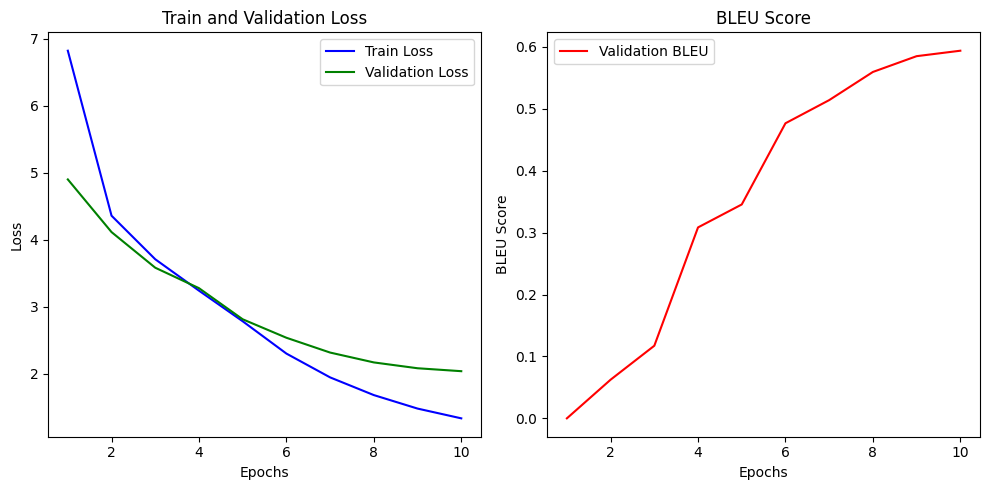

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

epochs = range(1, len(results["train_loss"]) + 1)
ax1.plot(epochs, results["train_loss"], "b-", label="Train Loss")
ax1.plot(epochs, results["valid_loss"], "g-", label="Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.set_title("Train and Validation Loss")

epochs = np.arange(1, len(results["bleu"]) + 1)
ax2.plot(epochs, results["bleu"], "r-", label="Validation BLEU")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("BLEU Score")
ax2.legend()
ax2.set_title("BLEU Score")

plt.tight_layout()
plt.savefig("training_results.png", dpi=300, bbox_inches="tight")
plt.show()

In [61]:
def check_outputs(valid_dataloader, model, src_tokenizer, tgt_tokenizer, n_examples, decoding_strategy):
    model = model.to(DEVICE).eval()
    pad_idx = tgt_tokenizer.pad_token_id
    start_idx = tgt_tokenizer.bos_token_id
    end_idx = tgt_tokenizer.eos_token_id
    eos_string = tgt_tokenizer.eos_token
    results = [()] * n_examples

    for idx, b in enumerate(valid_dataloader):
        if idx == n_examples:
            break
        print(f"\nExample {idx + 1} ========\n")
        src_tokens = [src_tokenizer.decode(x) for x in b.src[0] if x != pad_idx]
        tgt_tokens = [tgt_tokenizer.decode(x) for x in b.tgt_y[0] if x != pad_idx]

        print("Source Text (Input)        : " + " ".join(src_tokens).replace("\n", ""))
        print("Target Text (Ground Truth) : " + " ".join(tgt_tokens).replace("\n", ""))
        if decoding_strategy == "random":
            model_out = random_sampling(model, b.src, b.src_mask, 72, start_idx, end_idx)[0]
        else:
            model_out = greedy_sampling(model, b.src, b.src_mask, 72, start_idx, end_idx)[0]
        model_txt = " ".join([tgt_tokenizer.decode(x) for x in model_out if x != pad_idx]).split(eos_string, 1)[0] + eos_string
        print("Model Output               : " + model_txt.replace("\n", ""))
        results[idx] = (b, src_tokens, tgt_tokens, model_out, model_txt)
    return results


def inference(model_checkpoint, src_tokenizer, tgt_tokenizer, n_examples=5, decoding_strategy="greedy"):
    """
    Inference the model on the test set and print out some examples.

    Parameters
    ----------
    model_checkpoint: str
        Path to the trained model checkpoint
    src_tokenizer: Tokenizer
        Tokenizer for source sentences, German in our case
    tgt_tokenizer: Tokenizer
        Tokenizer for target sentences, English in our case
    n_examples: int
        Number of examples to print
    decoding_strategy: str
        Decoding strategy to use, either "greedy" or "random", remember to tune the temperature, top_k and top_p values if using random sampling
    """
    print("Preparing Data ...")
    _, _, test_dataloader = create_dataloaders(
        src_tokenizer,
        tgt_tokenizer,
        batch_size=1,
    )

    print("Loading Trained Model ...")

    model = make_model(src_tokenizer.vocab_size, tgt_tokenizer.vocab_size, N=configs.N_LAYERS)
    model.load_state_dict(torch.load(model_checkpoint))

    print("Checking Model Outputs:")
    example_data = check_outputs(test_dataloader, model, src_tokenizer, tgt_tokenizer, n_examples, decoding_strategy)
    return model, example_data

Performing inference on a few examples, we can see that the model is able to generate coherent sentences. However, the performance still seems a little off. Given that the model was trained for only 10 epochs, there's still more room for improvement with additional training.

In [62]:
en_tokenizer, de_tokenizer = load_tokenizers()
model, example_data = inference(model_checkpoint="models/multi30k_model_final.pt", src_tokenizer=de_tokenizer, tgt_tokenizer=en_tokenizer, n_examples=5, decoding_strategy="greedy")

Tokenizers loaded from local.
Preparing Data ...
Loading Trained Model ...


/tmp/ipykernel_210972/2034565918.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_checkpoint))


Checking Model Outputs:

Example 1 ========

Source Text (Input)        : Ein  Mann  mit  einem  orangefarbenen  Hut ,  der  etwas  an st arrt .
Target Text (Ground Truth) : A  man  in  an  orange  hat  starring  at  something
Model Output               : <bos> A  man  wearing  an  orange  hat  is  flipping  a  unique  instrument . <eos>

Example 2 ========

Source Text (Input)        : Ein  Boston  Terrier  läuft  über  saftig - grünes  Gras  vor  einem  weißen  Zaun .
Target Text (Ground Truth) : A  Boston  Terrier  is  running  on  lush  green  grass  in  front  of  a  white  fence
Model Output               : <bos> A  athlete  running  through  white  grass  in  front  of  a  white  gate . <eos>

Example 3 ========

Source Text (Input)        : Ein  Mädchen  in  einem  Karateanzug  bricht  ein  Brett  mit  einem  Tritt .
Target Text (Ground Truth) : A  girl  in  karate  uniform  breaking  a  stick  with  a  front  kick
Model Output               : <bos> A  girl  in  a  karate  unif

# References

- https://nlp.seas.harvard.edu/annotated-transformer/
- https://pi-tau.github.io/posts/transformer/
- https://eugeneyan.com/writing/attention/
- https://arxiv.org/pdf/1706.03762
- https://arxiv.org/pdf/2002.04745